In [1]:
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd
import os
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch import optim
import time
from torch.utils.data import Dataset, DataLoader
import torchaudio
import torchvision.transforms as transforms
import matplotlib.pyplot as plt

from sklearn.preprocessing import label_binarize
from sklearn.utils.multiclass import unique_labels
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_curve, auc
from itertools import cycle

In [2]:
device = torch.device('cuda')

In [3]:
def random_sampling_and_normalization(sample,sampling_length=256*256,padding=10):
    length = sample.size(1)
    if length<sampling_length:
        pad = int((sampling_length-length)/2)
        sample = torch.cat((torch.zeros((1,pad)),sample,torch.zeros((1,pad))),-1)
    sample = torch.cat((torch.zeros((1,padding)),sample,torch.zeros((1,padding))),-1)
    length = sample.size(1)
    random_num = np.random.randint(low=0, high=(length-sampling_length-1))
    sample = sample[:,random_num:random_num+sampling_length]
    
    #normalization
    #channel=（channel-mean）/std
    mean = 2e-05
    std = 0.05
    sample = (sample-mean)/std
    return sample

In [4]:
def center_sampling_and_normalization(sample,sampling_length=256*256):
    length = sample.size(1)
    if length<sampling_length:
        pad = int(sampling_length-length)
        sample = torch.cat((sample,torch.zeros((1,pad))),-1)
    sample = sample[:,:sampling_length]
    #normalization
    #channel=（channel-mean）/std
    mean = 2e-05
    std = 0.05
    sample = (sample-mean)/std
    return sample

In [5]:
class my_dataset(Dataset):
    def __init__(self, df_path, train = False):
        self.df = pd.read_csv(df_path)
        self.train = train
        
    def __len__(self):
        return len(self.df)
    
    def __getitem__(self,idx):
        sample_1_name = self.df.iloc[idx]['sample 1']
        sample_1_path = '/scratch/cz2064/myjupyter/Time_Series/Data/data_VoxCeleb/wav/'+sample_1_name
        sample_1,_ = torchaudio.load(sample_1_path)
        
        sample_2_name = self.df.iloc[idx]['sample 2']
        sample_2_path = '/scratch/cz2064/myjupyter/Time_Series/Data/data_VoxCeleb/wav/'+sample_2_name
        sample_2,_ = torchaudio.load(sample_2_path)
        
        if self.train:
            sample_1_tensor = random_sampling_and_normalization(sample_1)
            sample_2_tensor = random_sampling_and_normalization(sample_2)
        else:
            sample_1_tensor = center_sampling_and_normalization(sample_1)
            sample_2_tensor = center_sampling_and_normalization(sample_2)
            
            
        label = self.df.loc[idx,'True or False']
        label = torch.tensor(label, dtype=torch.long)
        
        sample = {'x1': sample_1_tensor, 'x2': sample_2_tensor, 'y': label}
        
        return sample

In [6]:
train_df_path = '/scratch/cz2064/myjupyter/Time_Series/notebook/train.csv'
val_df_path = '/scratch/cz2064/myjupyter/Time_Series/notebook/val.csv'
test_df_path = '/scratch/cz2064/myjupyter/Time_Series/notebook/test.csv'
BATCH_SIZE = 32
#train_loader = DataLoader(my_dataset(train_df_path,train = True), batch_size=BATCH_SIZE, shuffle=True)
train_sampler = torch.utils.data.sampler.RandomSampler(my_dataset(train_df_path,train = True)\
                                                       ,num_samples=50000,replacement=True)
train_loader = DataLoader(my_dataset(train_df_path,train = True), batch_size=BATCH_SIZE, \
                          sampler = train_sampler,num_workers=16)
val_loader = DataLoader(my_dataset(val_df_path), batch_size=BATCH_SIZE, shuffle=True,num_workers=16)
test_loader = DataLoader(my_dataset(test_df_path), batch_size=BATCH_SIZE, shuffle=True)

In [7]:
iter_ = iter(train_loader)
sample_1 = next(iter_)['x1']
sample_2 = next(iter_)['x2']

In [8]:
sample_1.size()

torch.Size([32, 1, 65536])

In [9]:
cfg = {
    'VGG11': [64, 'M', 128, 'M', 256, 256, 'M', 512, 512, 'M', 512, 512, 'M'],
    'VGG13': [64, 64, 'M', 128, 128, 'M', 256, 256, 'M', 512, 512, 'M', 512, 512, 'M'],
    'VGG16': [64, 64, 'M', 128, 128, 'M', 256, 256, 256, 'M', 512, 512, 512, 'M', 512, 512, 512, 'M'],
    'VGG19': [64, 64, 'M', 128, 128, 'M', 256, 256, 256, 256, 'M', 512, 512, 512, 512, 'M', 512, 512, 512, 512, 'M'],
}


class VGG_1D(nn.Module):
    def __init__(self, vgg_name):
        super(VGG_1D, self).__init__()
        self.features = self._make_layers(cfg[vgg_name])
        #self.classifier = nn.Linear(512, 10)

        
    def forward(self, x):
        out = self.features(x)
        out = out.view(out.size(0), -1)
        #out = self.classifier(out)
        return out

    def _make_layers(self, cfg):
        layers = []
        in_channels = 1
        for x in cfg:
            if x == 'M':
                layers += [nn.MaxPool1d(kernel_size=5, stride=5)]
            else:
                layers += [nn.Conv1d(in_channels, x, kernel_size=10, padding=5),
                           nn.BatchNorm1d(x),
                           nn.ReLU(inplace=True)]
                in_channels = x
        layers += [nn.AvgPool1d(21)]
        return nn.Sequential(*layers)

In [10]:
model_CNN = VGG_1D('VGG16')

In [11]:
model_CNN(sample_1).size()

torch.Size([32, 512])

In [12]:
class MyModel(nn.Module):
    def __init__(self):
        super(MyModel, self).__init__()
        self.cnn = model_CNN
        self.fc1 = nn.Linear(512*3,2048)
        self.activation_fc1 = nn.ReLU()
        self.dropout1 = nn.Dropout(p=0.5)
        self.fc2 = nn.Linear(2048,1024)
        self.activation_fc2 = nn.ReLU()
        self.fc3 = nn.Linear(1024,2)
        
    def forward(self, x1, x2):
        x1 = self.cnn(x1)
        x2 = self.cnn(x2)
        
        x_add = x1+x2
        x_minus = x1-x2
        x_multiply = x1*x2
        x = torch.cat((x_add, x_minus, x_multiply),-1)
        x = self.fc1(x)
        x = self.activation_fc1(x)
        x = self.dropout1(x)
        x = self.fc2(x)
        x = self.activation_fc2(x)
        x = self.fc3(x)
        return x

In [13]:
model = MyModel()

In [14]:
model(sample_1,sample_2).size()

KeyboardInterrupt: 

## Train

In [ ]:
def train(model, train_loader=train_loader, val_loader=val_loader, learning_rate=1e-4, num_epoch=100):
    start_time = time.time()

    loss_fn = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(),lr=learning_rate)
    
    train_loss_return = []
    train_acc_return = []
    val_loss_return = []
    val_acc_return = []
    best_acc = 0
    
    for epoch in range(num_epoch):
        # Training steps
        correct = 0
        total = 0
        predictions = []
        truths = []
        model.train()
        train_loss_list = []
        for i, (sample) in enumerate(train_loader):
            sample_1 = sample['x1'].to(device)
            sample_2 = sample['x2'].to(device)
            labels = sample['y'].to(device)
            outputs = model(sample_1,sample_2)
            pred = outputs.data.max(-1)[1]
            predictions += list(pred.cpu().numpy())
            truths += list(labels.cpu().numpy())
            total += labels.size(0)
            correct += (pred == labels).sum()
            model.zero_grad()
            loss = loss_fn(outputs, labels)
            print(loss)
            train_loss_list.append(loss.item())
            loss.backward()
            optimizer.step()
        # report performance
        acc = (100 * correct / total)
        train_acc_return.append(acc)
        train_loss_every_epoch = np.average(train_loss_list)
        train_loss_return.append(train_loss_every_epoch)
        print('----------Epoch{:2d}/{:2d}----------'.format(epoch+1,num_epoch))
        print('Train set | Loss: {:6.4f} | Accuracy: {:4.2f}% '.format(train_loss_every_epoch, acc))
        
        # Evaluate after every epochh
        correct = 0
        total = 0
        model.eval()
        predictions = []
        truths = []
        val_loss_list = []
        with torch.no_grad():
            for i, (sample) in enumerate(val_loader):
                sample_1 = sample['x1'].to(device)
                sample_2 = sample['x2'].to(device)
                labels = sample['y'].to(device)
                outputs = model(sample_1,sample_2)
                loss = loss_fn(outputs, labels)
                val_loss_list.append(loss.item())
                pred = outputs.data.max(-1)[1]
                predictions += list(pred.cpu().numpy())
                truths += list(labels.cpu().numpy())
                total += labels.size(0)
                correct += (pred == labels).sum()
            # report performance
            acc = (100 * correct / total)
            val_acc_return.append(acc)
            val_loss_every_epoch = np.average(val_loss_list)
            val_loss_return.append(val_loss_every_epoch)
            if acc > best_acc:
                best_acc = acc
                best_model_wts = model.state_dict()
            save_model(model,train_loss_return,train_acc_return,val_loss_return,val_acc_return,best_model_wts)
            elapse = time.strftime('%H:%M:%S', time.gmtime(int((time.time() - start_time))))
            print('Test set | Loss: {:6.4f} | Accuracy: {:4.2f}% | time elapse: {:>9}'\
                  .format(val_loss_every_epoch, acc,elapse))
    return model,train_loss_return,train_acc_return,val_loss_return,val_acc_return,best_model_wts

def save_model(model,train_loss_return,train_acc_return,val_loss_return,val_acc_return,best_model_wts):
    state = {'best_model_wts':best_model_wts, 'model':model, \
             'train_loss':train_loss_return, 'train_acc':train_acc_return,\
             'val_loss':val_loss_return, 'val_acc':val_acc_return}
    torch.save(state, 'checkpoint_CNN.pt')
    return None

In [18]:
model = MyModel().to(device)

In [19]:
path = '/scratch/cz2064/myjupyter/Time_Series/notebook/python_files/Model_CNN_VGG16/checkpoint_CNN.pt'
model.load_state_dict(torch.load(path)['best_model_wts'])

<All keys matched successfully>

In [17]:
train(model)

tensor(0.7179, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(0.9400, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(0.7206, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(0.7178, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(0.7211, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(0.7237, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(0.7362, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(0.6903, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(0.6689, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(0.6719, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(0.7130, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(0.6571, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(0.7145, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(0.7237, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(0.6758, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(0.7031, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(0.7047, device='cuda:0', grad_fn=<NllLossBackward

tensor(0.5875, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(0.5481, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(0.7219, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(0.6435, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(0.6752, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(0.6222, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(0.5438, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(0.7469, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(0.4442, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(0.6136, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(0.6435, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(0.5784, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(0.5874, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(0.6756, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(0.6158, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(0.6358, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(0.4888, device='cuda:0', grad_fn=<NllLossBackward

tensor(0.6465, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(0.5412, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(0.4748, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(0.5791, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(0.7013, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(0.5974, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(0.6126, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(0.5903, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(0.6330, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(0.7155, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(0.6124, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(0.6959, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(0.4856, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(0.5981, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(0.4751, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(0.5219, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(0.6276, device='cuda:0', grad_fn=<NllLossBackward

tensor(0.5080, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(0.6567, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(0.6044, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(0.5880, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(0.7414, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(0.5832, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(0.5015, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(0.6330, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(0.5248, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(0.5677, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(0.4599, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(0.5138, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(0.4667, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(0.6389, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(0.7690, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(0.5106, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(0.5316, device='cuda:0', grad_fn=<NllLossBackward

KeyboardInterrupt: 

## Evaluate

In [15]:
model = MyModel().to(device)

In [16]:
model.load_state_dict(torch.load('/scratch/cz2064/myjupyter/Time_Series/notebook/python_files/\
Model_CNN_VGG16/checkpoint_CNN.pt',map_location=torch.device(device))['best_model_wts'])

<All keys matched successfully>

In [17]:
test_df_path = '/scratch/cz2064/myjupyter/Time_Series/notebook/test.csv'
test_loader = DataLoader(my_dataset(test_df_path), batch_size=1, shuffle=False)

In [18]:
def evaluate_model(model, dataloader):   
    model.eval()
    y_true = []
    y_score = []
    y_pre = []
    
    model.eval()
    for i, (sample) in enumerate(dataloader):
        sample_1 = sample['x1'].to(device)
        sample_2 = sample['x2'].to(device)
        label = sample['y'].to('cpu',dtype=torch.long)
        y_true += label.tolist()

        output = model(sample_1,sample_2)
        output = F.softmax(output,dim=1)
        output = output.to('cpu')
        if y_score == []:
            y_score = np.array(output.detach().numpy())
        else:
            y_score = np.concatenate((y_score,output.detach().numpy()),axis = 0)
    for i in y_score:
        y_pre.append(list(i).index(max(i)))
    return y_true,y_pre,y_score

In [19]:
y_true,y_pre,y_score = evaluate_model(model, test_loader)

In [20]:
test_df = pd.read_csv(test_df_path)
test_df['pre'] = y_pre
test_df['score'] = np.expand_dims(np.array(y_score),2)[:,1]

In [21]:
test_df.head()

,True or False,sample 1,sample 2,pre,score
0,1,id10270/x6uYqmx31kE/00001.wav,id10270/8jEAjG6SegY/00008.wav,1,0.697631
1,0,id10270/x6uYqmx31kE/00001.wav,id10300/ize_eiCFEg0/00003.wav,0,0.000293
2,1,id10270/x6uYqmx31kE/00001.wav,id10270/GWXujl-xAVM/00017.wav,1,0.754381
3,0,id10270/x6uYqmx31kE/00001.wav,id10273/0OCW1HUxZyg/00001.wav,0,0.008987
4,1,id10270/x6uYqmx31kE/00001.wav,id10270/8jEAjG6SegY/00022.wav,1,0.943433


In [22]:
test_df.to_csv('Pre_VGG_16.csv', index = False)

In [23]:
def ROC_curve(y_test,y_score):
    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    n_classes = y_test.shape[1]
    for i in range(n_classes):
        fpr[i], tpr[i], _ = roc_curve(y_test[:, i], y_score[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])

    colors = cycle(['aqua', 'darkorange', 'cornflowerblue'])
    lw = 2
    for i, color in zip(range(n_classes), colors):
        plt.plot(fpr[i], tpr[i], color=color, lw=lw,
                 label='ROC curve of class {0} (area = {1:0.2f})'
                 ''.format(i, roc_auc[i]))
    plt.plot([0, 1], [0, 1], 'k--', lw=lw)
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Some extension of Receiver operating characteristic to multi-class')
    plt.legend(loc="lower right")
    plt.show()
    return None

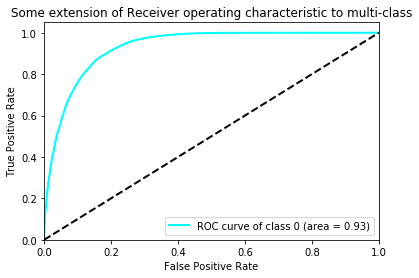

In [24]:
ROC_curve(np.expand_dims(np.array(y_true),1),np.expand_dims(np.array(y_score),2)[:,1])